##Importing Data

In [ ]:
import math
import pandas as pd
import numpy as np
from matplotlib import style
import matplotlib.pyplot as plt
import sklearn.cluster as skcluster
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import MinMaxScaler

plt.style.use('dark_background')
df = pd.read_csv("spotify_data.csv", encoding="latin-1")
df["track_name"].unique()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

## Data Preprocessing

In [ ]:
df.isna().sum()
df.dropna(inplace=True)
df.isna().sum()
for col in df:
    print (df[col])
    print(df[col].unique())
df["streams"].unique()
for index, entry in df['streams'].items():
    try:
        numeric_entry = pd.to_numeric(entry, errors='coerce')
        if not numeric_entry >= 0:
            print(f'{index}: {numeric_entry}')
            print(f'Real Data Present= {entry}')
    except ValueError:
        pass
prod_df= df.drop(574)
prod_df["streams"].unique()
df = prod_df
convert_to_string = {'track_name', 'artist(s)_name', 'key', 'mode'}
convert_to_numeric = {"in_deezer_playlists", "in_shazam_charts"}
for col_name in convert_to_string:
    df[col_name] = df[col_name].astype("string")
for col_name in convert_to_numeric:
    df[col_name] = df[col_name].str.replace(',', '').astype(np.int64)
df["streams"] = df["streams"].astype(np.int64)
df.drop("track_name", axis=1, inplace=True)
df.sort_values("streams", ascending = False)
lower_bound = df["streams"].quantile(0.01)
df_filtered = df[df["streams"] > lower_bound]
df_filtered.sort_values("streams", ascending = False)
df.sort_values("in_spotify_charts", ascending = False)
df['in_spotify_charts'].value_counts()

0      Seven (feat. Latto) (Explicit Ver.)
1                                     LALA
2                                  vampire
3                             Cruel Summer
4                           WHERE SHE GOES
                      ...                 
948                           My Mind & Me
949              Bigger Than The Whole Sky
950                   A Veces (feat. Feid)
951                          En La De Ella
952                                  Alone
Name: track_name, Length: 817, dtype: object
['Seven (feat. Latto) (Explicit Ver.)' 'LALA' 'vampire' 'Cruel Summer'
 'WHERE SHE GOES' 'Sprinter' 'Ella Baila Sola' 'Columbia' 'fukumean'
 'La Bebe - Remix' 'un x100to' 'Super Shy' 'Daylight' 'Kill Bill'
 'Cupid - Twin Ver.' 'Classy 101' 'Like Crazy' 'LADY GAGA'
 'I Can See You (Taylorï¿½ï¿½ï¿½s Version) (From The '
 'Peso Pluma: Bzrp Music Sessions, Vol. 55'
 'Popular (with Playboi Carti & Madonna) - The Idol Vol. 1 (Music from the HBO Original Series)'
 'SABOR FRESA' 'Calm 

in_spotify_charts
0     347
4      41
2      36
6      31
8      16
     ... 
79      1
66      1
41      1
62      1
37      1
Name: count, Length: 76, dtype: int64

## Descriptive Statistics for Continuous Data

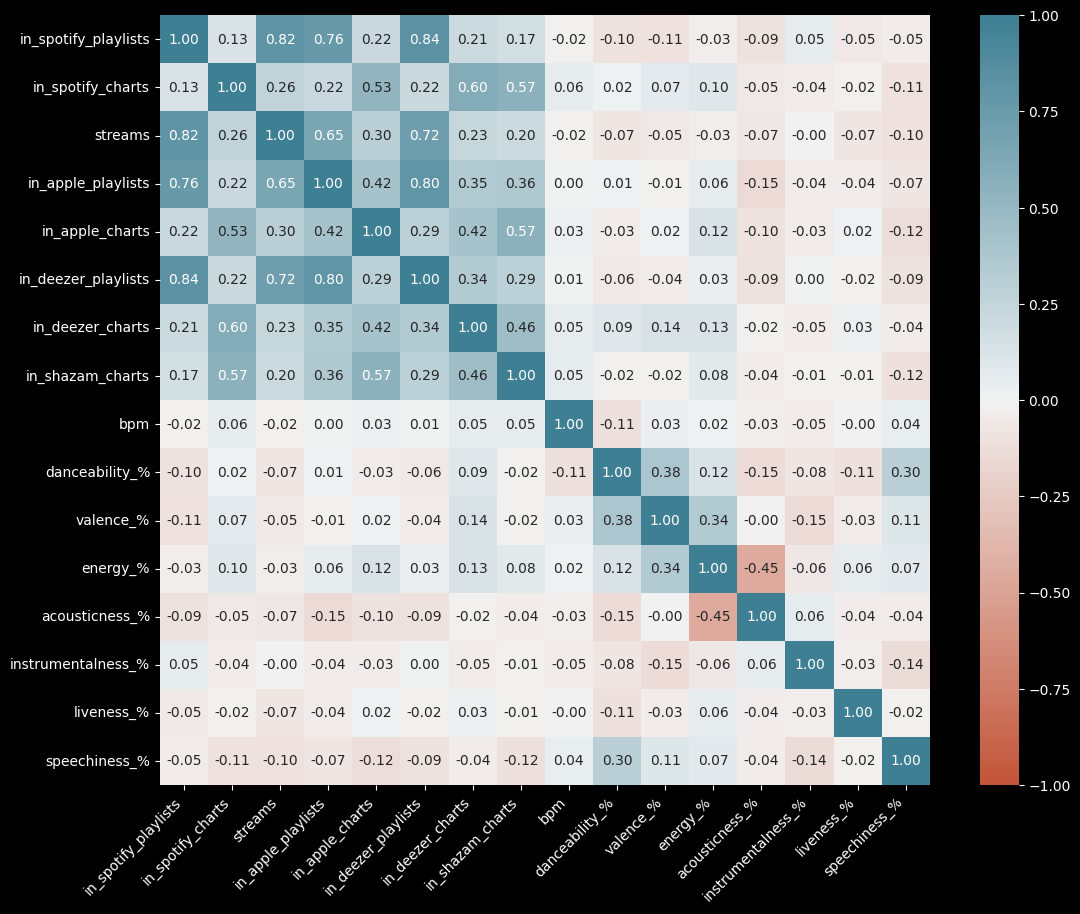

In [ ]:
corr_matrix = df[["in_spotify_playlists",
                  "in_spotify_charts",
                  "streams",
                  "in_apple_playlists",
                  "in_apple_charts",
                  "in_deezer_playlists",
                  "in_deezer_charts",
                  "in_shazam_charts",
                  "bpm",
                  "key",
                  "mode",
                  "danceability_%",
                  "valence_%",
                  "energy_%",
                  "acousticness_%",
                  "instrumentalness_%",
                  "liveness_%",
                  "speechiness_%"]].corr(method='spearman', numeric_only=True)
corr_matrix
fig, ax = plt.subplots(figsize=(13, 10))
ax = sns.heatmap(
    corr_matrix,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    fmt = '0.2f',
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

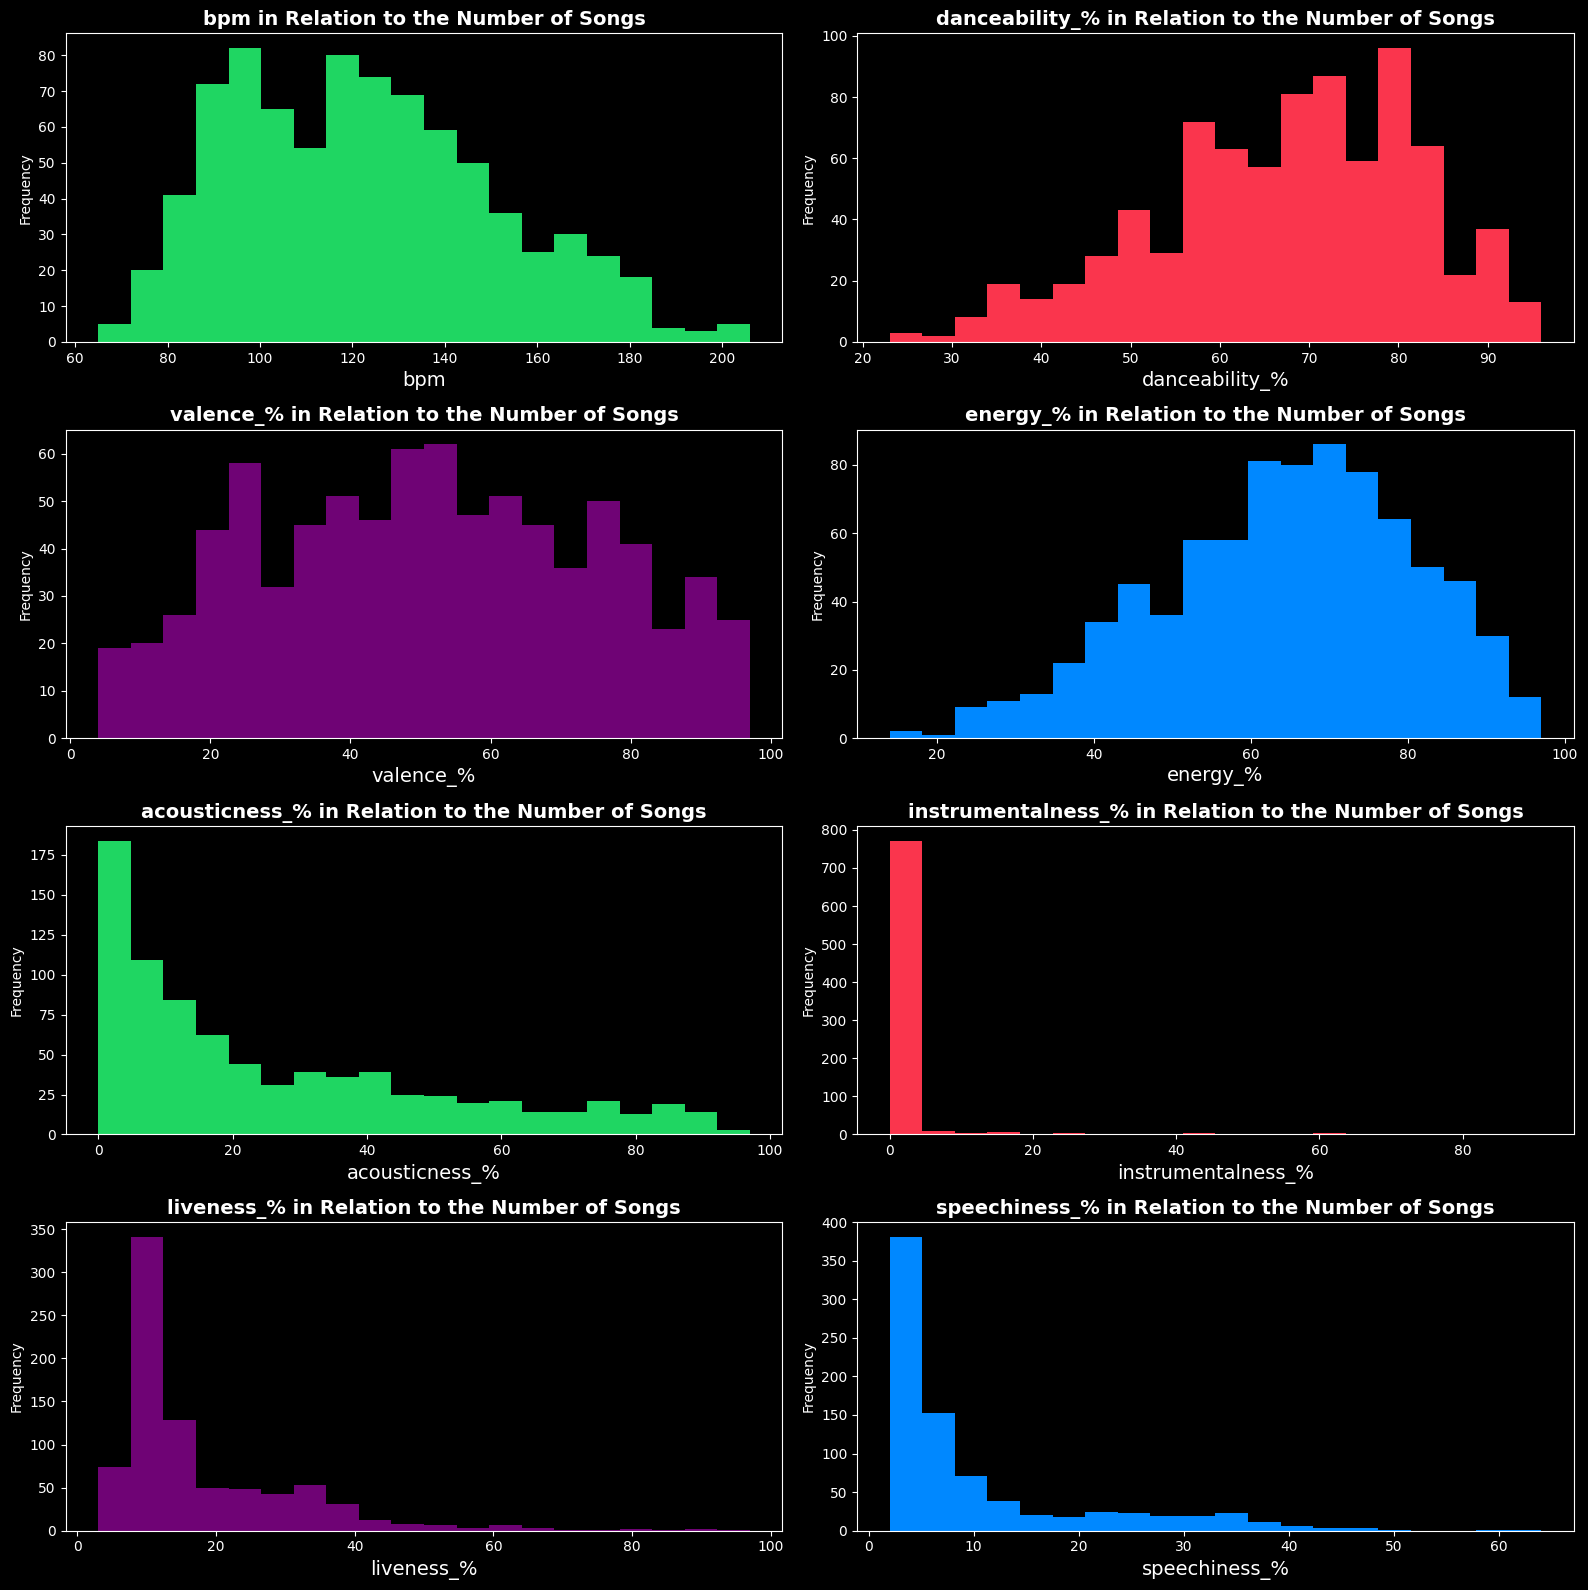

In [ ]:
columns_to_plot = ['bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']
colors = ["#1FD662", "#FA354D", "#6F0375", "#0088FF", "#1FD662", "#FA354D", "#6F0375", "#0088FF"]
num_columns = len(columns_to_plot)
num_rows = math.ceil(num_columns / 2)
fig, axes = plt.subplots(num_rows, 2, figsize=(16, 16))
for i, column in enumerate(columns_to_plot):
    ax = axes[i // 2, i % 2]
    ax.hist(df[column], color=colors[i], bins=20)
    ax.set_xlabel(f"{column}", fontsize=14)
    ax.set_ylabel("Frequency")
    ax.set_title(f"{column} in Relation to the Number of Songs", fontsize=14, weight = "bold")
for i in range(num_columns, num_rows * 2):
    fig.delaxes(axes.flatten()[i])
plt.tight_layout()
plt.show()

In [ ]:
df.agg({"bpm" : ["median", "mean", "std"]})

,bpm
median,120.000000
mean,122.580882
std,28.188643


## Exploratory Data Analysis

### Song Features Correlation with Popularity Metrics

BPM vs Streams and Popularity on charts

In [ ]:
# Calculate Spearman correlation matrix for each pair of attributes
spearman_corr_streams = df[["bpm", "streams"]].corr(method='spearman')
spearman_corr_spotify_charts = df[["bpm", "in_spotify_charts"]].corr(method='spearman')
spearman_corr_apple_charts = df[["bpm", "in_apple_charts"]].corr(method='spearman')
spearman_corr_deezer_charts = df[["bpm", "in_deezer_charts"]].corr(method='spearman')
spearman_corr_shazam_charts = df[["bpm", "in_shazam_charts"]].corr(method='spearman')

# Display each correlation matrix
print("Spearman Correlation with Streams:")
print(spearman_corr_streams)

print("\nSpearman Correlation with Spotify Charts:")
print(spearman_corr_spotify_charts)

print("\nSpearman Correlation with Apple Charts:")
print(spearman_corr_apple_charts)

print("\nSpearman Correlation with Deezer Charts:")
print(spearman_corr_deezer_charts)

print("\nSpearman Correlation with Shazam Charts:")
print(spearman_corr_shazam_charts)


Spearman Correlation with Streams:
              bpm   streams
bpm      1.000000 -0.015905
streams -0.015905  1.000000

Spearman Correlation with Spotify Charts:
                        bpm  in_spotify_charts
bpm                1.000000           0.055359
in_spotify_charts  0.055359           1.000000

Spearman Correlation with Apple Charts:
                      bpm  in_apple_charts
bpm              1.000000         0.026896
in_apple_charts  0.026896         1.000000

Spearman Correlation with Deezer Charts:
                       bpm  in_deezer_charts
bpm               1.000000          0.050127
in_deezer_charts  0.050127          1.000000

Spearman Correlation with Shazam Charts:
                       bpm  in_shazam_charts
bpm               1.000000          0.050306
in_shazam_charts  0.050306          1.000000


Danceability vs Streams and Popularity Charts


In [ ]:
# Spearman correlation with danceability
spearman_corr_danceability_streams = df[["danceability_%", "streams"]].corr(method='spearman')
spearman_corr_danceability_spotify_charts = df[["danceability_%", "in_spotify_charts"]].corr(method='spearman')
spearman_corr_danceability_apple_charts = df[["danceability_%", "in_apple_charts"]].corr(method='spearman')
spearman_corr_danceability_deezer_charts = df[["danceability_%", "in_deezer_charts"]].corr(method='spearman')
spearman_corr_danceability_shazam_charts = df[["danceability_%", "in_shazam_charts"]].corr(method='spearman')

# Display spearman correlation with danceability
print("Spearman Correlation with Danceability (Streams):")
print(spearman_corr_danceability_streams)

print("\nSpearman Correlation with Danceability (Spotify Charts):")
print(spearman_corr_danceability_spotify_charts)

print("\nSpearman Correlation with Danceability (Apple Charts):")
print(spearman_corr_danceability_apple_charts)

print("\nSpearman Correlation with Danceability (Deezer Charts):")
print(spearman_corr_danceability_deezer_charts)

print("\nSpearman Correlation with Danceability (Shazam Charts):")
print(spearman_corr_danceability_shazam_charts)


Spearman Correlation with Danceability (Streams):
                danceability_%   streams
danceability_%        1.000000 -0.074399
streams              -0.074399  1.000000

Spearman Correlation with Danceability (Spotify Charts):
                   danceability_%  in_spotify_charts
danceability_%           1.000000           0.022871
in_spotify_charts        0.022871           1.000000

Spearman Correlation with Danceability (Apple Charts):
                 danceability_%  in_apple_charts
danceability_%         1.000000        -0.033118
in_apple_charts       -0.033118         1.000000

Spearman Correlation with Danceability (Deezer Charts):
                  danceability_%  in_deezer_charts
danceability_%          1.000000          0.091191
in_deezer_charts        0.091191          1.000000

Spearman Correlation with Danceability (Shazam Charts):
                  danceability_%  in_shazam_charts
danceability_%          1.000000         -0.016494
in_shazam_charts       -0.016494      

Valence vs Steams and Popularity Charts

In [ ]:
# Spearman correlation with valence
spearman_corr_valence_streams = df[["valence_%", "streams"]].corr(method='spearman')
spearman_corr_valence_spotify_charts = df[["valence_%", "in_spotify_charts"]].corr(method='spearman')
spearman_corr_valence_apple_charts = df[["valence_%", "in_apple_charts"]].corr(method='spearman')
spearman_corr_valence_deezer_charts = df[["valence_%", "in_deezer_charts"]].corr(method='spearman')
spearman_corr_valence_shazam_charts = df[["valence_%", "in_shazam_charts"]].corr(method='spearman')

# Display spearman correlation with valence
print("Spearman Correlation with Valence (Streams):")
print(spearman_corr_valence_streams)

print("\nSpearman Correlation with Valence (Spotify Charts):")
print(spearman_corr_valence_spotify_charts)

print("\nSpearman Correlation with Valence (Apple Charts):")
print(spearman_corr_valence_apple_charts)

print("\nSpearman Correlation with Valence (Deezer Charts):")
print(spearman_corr_valence_deezer_charts)

print("\nSpearman Correlation with Valence (Shazam Charts):")
print(spearman_corr_valence_shazam_charts)


Spearman Correlation with Valence (Streams):
           valence_%   streams
valence_%   1.000000 -0.051814
streams    -0.051814  1.000000

Spearman Correlation with Valence (Spotify Charts):
                   valence_%  in_spotify_charts
valence_%           1.000000           0.065847
in_spotify_charts   0.065847           1.000000

Spearman Correlation with Valence (Apple Charts):
                 valence_%  in_apple_charts
valence_%         1.000000         0.020055
in_apple_charts   0.020055         1.000000

Spearman Correlation with Valence (Deezer Charts):
                  valence_%  in_deezer_charts
valence_%           1.00000           0.13542
in_deezer_charts    0.13542           1.00000

Spearman Correlation with Valence (Shazam Charts):
                  valence_%  in_shazam_charts
valence_%          1.000000         -0.015021
in_shazam_charts  -0.015021          1.000000


Energy vs Steams and Popularity Charts

In [ ]:
# Spearman correlation with energy
spearman_corr_energy_streams = df[["energy_%", "streams"]].corr(method='spearman')
spearman_corr_energy_spotify_charts = df[["energy_%", "in_spotify_charts"]].corr(method='spearman')
spearman_corr_energy_apple_charts = df[["energy_%", "in_apple_charts"]].corr(method='spearman')
spearman_corr_energy_deezer_charts = df[["energy_%", "in_deezer_charts"]].corr(method='spearman')
spearman_corr_energy_shazam_charts = df[["energy_%", "in_shazam_charts"]].corr(method='spearman')

# Display spearman correlation with energy
print("Spearman Correlation with Energy (Streams):")
print(spearman_corr_energy_streams)

print("\nSpearman Correlation with Energy (Spotify Charts):")
print(spearman_corr_energy_spotify_charts)

print("\nSpearman Correlation with Energy (Apple Charts):")
print(spearman_corr_energy_apple_charts)

print("\nSpearman Correlation with Energy (Deezer Charts):")
print(spearman_corr_energy_deezer_charts)

print("\nSpearman Correlation with Energy (Shazam Charts):")
print(spearman_corr_energy_shazam_charts)


Spearman Correlation with Energy (Streams):
          energy_%   streams
energy_%  1.000000 -0.026278
streams  -0.026278  1.000000

Spearman Correlation with Energy (Spotify Charts):
                   energy_%  in_spotify_charts
energy_%           1.000000           0.095199
in_spotify_charts  0.095199           1.000000

Spearman Correlation with Energy (Apple Charts):
                 energy_%  in_apple_charts
energy_%         1.000000         0.123205
in_apple_charts  0.123205         1.000000

Spearman Correlation with Energy (Deezer Charts):
                  energy_%  in_deezer_charts
energy_%          1.000000          0.130214
in_deezer_charts  0.130214          1.000000

Spearman Correlation with Energy (Shazam Charts):
                  energy_%  in_shazam_charts
energy_%          1.000000          0.078819
in_shazam_charts  0.078819          1.000000


### Relationship between BPM and Danceability



In [ ]:
bpm_danceability_df = df[["bpm", "danceability_%"]]
bpm_danceability_df.corr()

,bpm,danceability_%
bpm,1.000000,-0.148816
danceability_%,-0.148816,1.000000


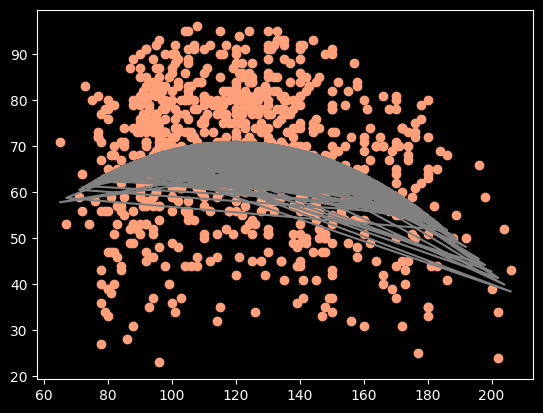

In [ ]:
plt.scatter(df["bpm"], df["danceability_%"], color = "#FFA07A")
z = np.polyfit(df["bpm"], df["danceability_%"], 2)
p = np.poly1d(z)
plt.plot(df["bpm"], p(df["bpm"]), "gray")

### Comparison across different Charts

In [ ]:
df[["in_spotify_charts", "in_apple_charts", "in_shazam_charts","in_deezer_charts"]].corr(method = 'spearman')

,in_spotify_charts,in_apple_charts,in_shazam_charts,in_deezer_charts
in_spotify_charts,1.000000,0.530754,0.568651,0.595192
in_apple_charts,0.530754,1.000000,0.568065,0.415508
in_shazam_charts,0.568651,0.568065,1.000000,0.464657
in_deezer_charts,0.595192,0.415508,0.464657,1.000000


### Relationship between Streams and Charts


In [ ]:
df[["streams", "in_spotify_charts"]].corr()

,streams,in_spotify_charts
streams,1.000000,0.214034
in_spotify_charts,0.214034,1.000000


##Stream Count vs Mode used

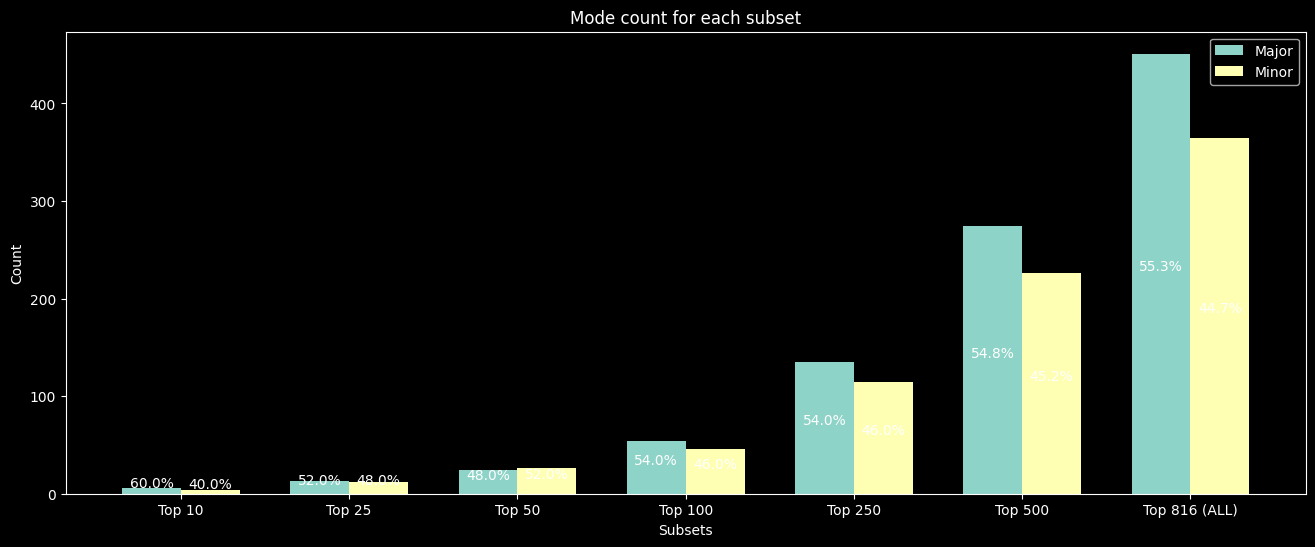

In [ ]:
major_count = []
minor_count = []
for num in subgrpnum:
  major_count.append(df.head(num).query('mode == "Major"').shape[0])
  minor_count.append(df.head(num).query('mode == "Minor"').shape[0])
bar_width = 0.35
index = np.arange(len(subgrps))
fig, ax = plt.subplots(figsize = (16,6))
bar1 = ax.bar(index, major_count, bar_width, label='Major')
bar2 = ax.bar(index + bar_width, minor_count, bar_width, label='Minor')
ax.set_xlabel('Subsets')
ax.set_ylabel('Count')
ax.set_title('Mode count for each subset')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(subgrps)
ax.legend()
total = [i+j for i,j in zip(major_count, minor_count)]
for rect1, rect2, total in zip(bar1, bar2, total):
    height1 = rect1.get_height()
    height2 = rect2.get_height()
    percentage1 = '{:.1%}'.format(height1/total)
    percentage2 = '{:.1%}'.format(height2/total)
    ax.text(rect1.get_x() + rect1.get_width() / 2., height1 / 2., percentage1 , ha='center', va='bottom')
    ax.text(rect2.get_x() + rect2.get_width() / 2., height2 / 2., percentage2 , ha='center', va='bottom')
plt.show()

<ipython-input-35-03c766cc34c8>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y="mode", x="streams", data=df, order=sorted_modes, palette=palette)


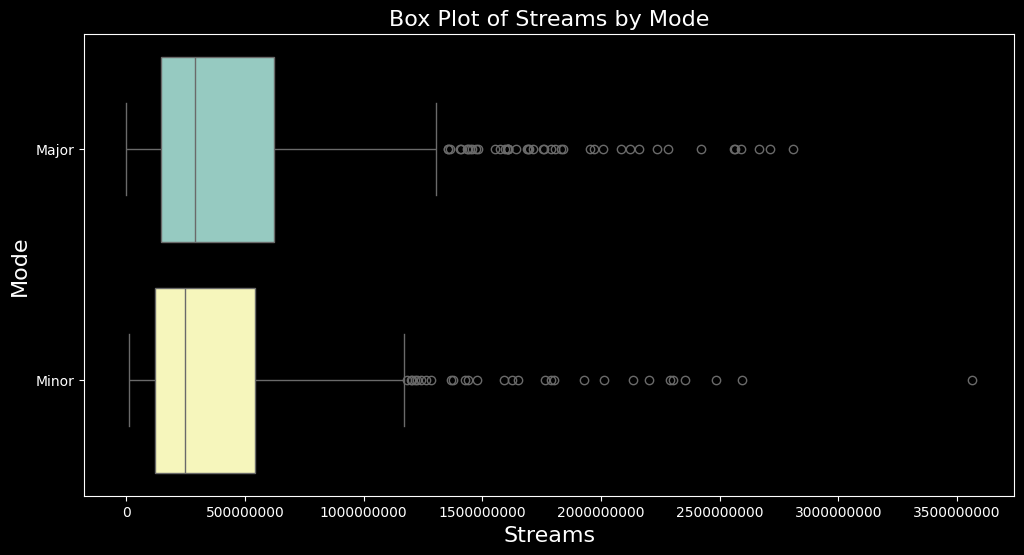

Outliers:
            artist(s)_name  artist_count  released_year  released_month  \
37            Taylor Swift             1           2014               1   
41   Post Malone, Swae Lee             2           2018              10   
47              The Weeknd             1           2016              11   
48   The Weeknd, Daft Punk             2           2016               9   
65           Chris Molitor             1           1999               1   
..                     ...           ...            ...             ...   
761             Ed Sheeran             1           2014               6   
762          Justin Bieber             1           2015              11   
790       Bad Bunny, Tainy             2           2019               5   
871          Guns N' Roses             1           1987               1   
910               Coldplay             1           2002               8   

     released_day  in_spotify_playlists  in_spotify_charts     streams  \
37             

In [ ]:
# Assuming df is your DataFrame

# Define palette and sort modes
palette = sns.color_palette("Set3", len(df['mode'].unique()))
sorted_modes = sorted(df['mode'].unique())

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(y="mode", x="streams", data=df, order=sorted_modes, palette=palette)

# Add labels and title
plt.xlabel("Streams", fontsize=16)
plt.ylabel("Mode", fontsize=16)
plt.title("Box Plot of Streams by Mode", fontsize=16)

# Ensure x-axis labels are not in scientific notation
plt.ticklabel_format(style='plain', axis='x')

# Show plot
plt.show()

# Detect and print outliers
Q1 = df['streams'].quantile(0.25)
Q3 = df['streams'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df['streams'] < (Q1 - 1.5 * IQR)) | (df['streams'] > (Q3 + 1.5 * IQR))]
print("Outliers:")
print(outliers)


In [ ]:
# Detect and print outliers for energy_% vs streams
Q1_energy_streams = df['energy_%'].quantile(0.25)
Q3_energy_streams = df['energy_%'].quantile(0.75)
IQR_energy_streams = Q3_energy_streams - Q1_energy_streams

outliers_energy_streams = df[(df['energy_%'] < (Q1_energy_streams - 1.5 * IQR_energy_streams)) | (df['energy_%'] > (Q3_energy_streams + 1.5 * IQR_energy_streams))]

print("Outliers for energy_% vs streams:")
print(outliers_energy_streams)

# Detect and print outliers for danceability_% vs streams
Q1_danceability_streams = df['danceability_%'].quantile(0.25)
Q3_danceability_streams = df['danceability_%'].quantile(0.75)
IQR_danceability_streams = Q3_danceability_streams - Q1_danceability_streams

outliers_danceability_streams = df[(df['danceability_%'] < (Q1_danceability_streams - 1.5 * IQR_danceability_streams)) | (df['danceability_%'] > (Q3_danceability_streams + 1.5 * IQR_danceability_streams))]

print("Outliers for danceability_% vs streams:")
print(outliers_danceability_streams)

# Detect and print outliers for valence_% vs streams
Q1_valence_streams = df['valence_%'].quantile(0.25)
Q3_valence_streams = df['valence_%'].quantile(0.75)
IQR_valence_streams = Q3_valence_streams - Q1_valence_streams

outliers_valence_streams = df[(df['valence_%'] < (Q1_valence_streams - 1.5 * IQR_valence_streams)) | (df['valence_%'] > (Q3_valence_streams + 1.5 * IQR_valence_streams))]

print("Outliers for valence_% vs streams:")
print(outliers_valence_streams)


Outliers for energy_% vs streams:
    artist(s)_name  artist_count  released_year  released_month  released_day  \
326    Mac DeMarco             1           2019               5            10   
460  Nat King Cole             1           1946              11             1   

     in_spotify_playlists  in_spotify_charts    streams  in_apple_playlists  \
326                  1640                  0  244658767                  27   
460                 11500                  0  389771964                 140   

     in_apple_charts  ...  bpm  key   mode  danceability_% valence_% energy_%  \
326               27  ...  150   G#  Minor              90        64       14   
460               72  ...  139   C#  Major              36        22       15   

     acousticness_%  instrumentalness_%  liveness_%  speechiness_%  
326              67                  35          11             10  
460              84                   0          11              4  

[2 rows x 23 columns]
Outliers f

## Main Problem Statement

What impact does the key of a song have on its streamability on Spotify?


# Song Characteristics through its audio features across all keys


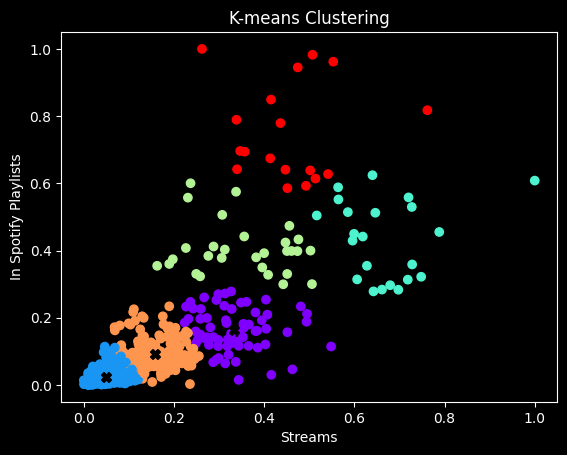

In [ ]:
data = df[["streams", "in_spotify_playlists"]].to_numpy()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
model1 = skcluster.KMeans(n_clusters=6, random_state=4, n_init=10, max_iter=1000)
model1.fit(scaled_data)
cluster_assignments = model1.labels_
centroids = model1.cluster_centers_
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=cluster_assignments, cmap='rainbow')
plt.scatter(centroids[:, 0], centroids[:, 1], s=50, color='black', marker='X', label='Centroids')
plt.xlabel('Streams')
plt.ylabel('In Spotify Playlists')
plt.title('K-means Clustering')
# plt.legend()
plt.show()

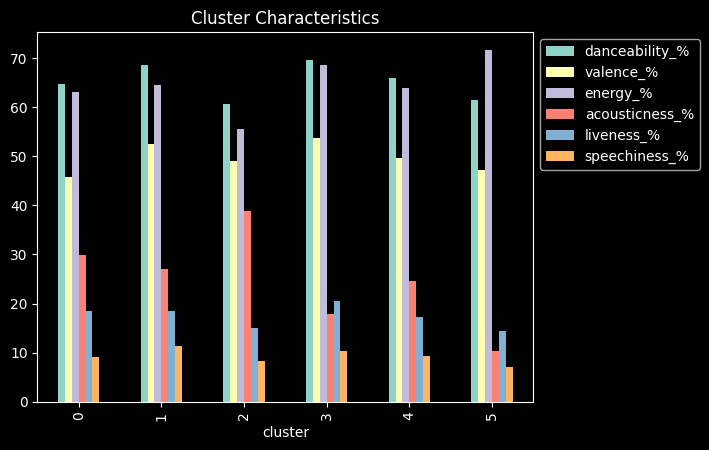

In [ ]:
clustered_df = df.copy()
cluster_labels = model1.labels_
clustered_df['cluster'] = cluster_labels
cluster_means = clustered_df[["cluster", "danceability_%", "valence_%", "energy_%", "acousticness_%", "liveness_%", "speechiness_%"]].groupby('cluster').mean()
cluster_means.plot(kind='bar')
plt.title('Cluster Characteristics')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

Now, we shall explore the distribution of the keys within each cluster through a pie chart

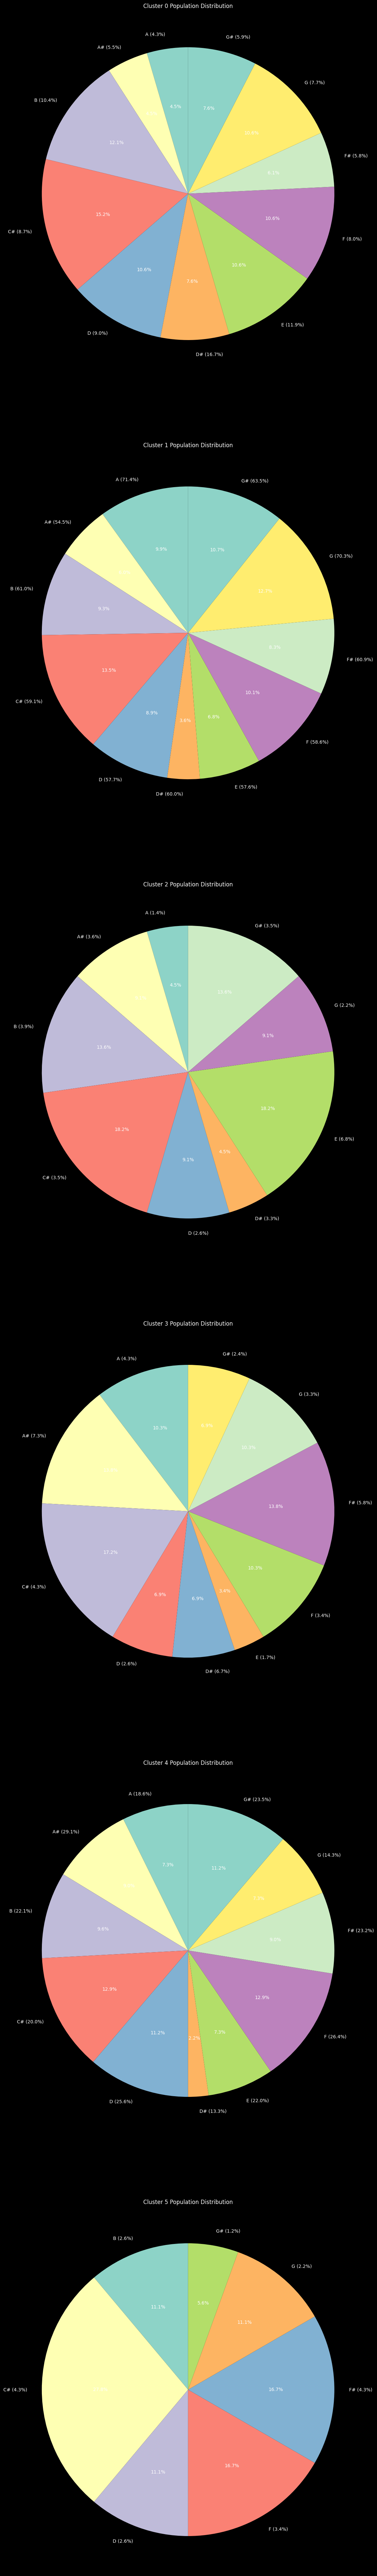

In [ ]:
cluster_key_dist = clustered_df.groupby('cluster')["key"].value_counts()
cluster_key_pop = clustered_df.groupby('cluster')["key"].value_counts().groupby("cluster").sum()

cluster_pop_distribution = pd.DataFrame({}, columns=["cluster", "key", "population"])

for index, value in cluster_key_dist.items():
  cluster, key = index
  cluster_pop_distribution.loc[len(cluster_pop_distribution.index)] = [cluster, key, value]

grouped_cluster_pop_distribution = cluster_pop_distribution.groupby("cluster")

key_pop = pd.DataFrame({})

key_pop['key'] = df['key'].unique()
key_pop['population'] = key_pop['key'].map(df['key'].value_counts())
key_pop = key_pop.sort_values(by=['key']).reset_index(drop=True)

fig, axs = plt.subplots(nrows=len(grouped_cluster_pop_distribution.groups.keys()), figsize=(130, 100))
for index, name in enumerate(grouped_cluster_pop_distribution.groups.keys()):
  new_clustered_df = grouped_cluster_pop_distribution.get_group(name).sort_values(by="key")
  new_clustered_df['population_percentage'] = new_clustered_df['population'] / new_clustered_df['key'].map(key_pop.set_index('key')['population']) * 100
  labels = [f'{key} ({pop:.1f}%)' for key, pop in zip(new_clustered_df["key"], new_clustered_df["population_percentage"])]
  axs[index].pie(new_clustered_df["population"], labels=labels, autopct='%1.1f%%', startangle=90)
  axs[index].set_title(f'Cluster {name} Population Distribution')
plt.show()


##ANOVA

In [ ]:
variance_check_df = pd.DataFrame({}, columns=['key', 'danceability_%_std', 'valence_%_std', 'energy_%_std', 'acousticness_%_std', 'liveness_%_std', 'speechiness_%_std', 'instrumentalness_%_std'])
variance_check_df['key'] = df['key'].unique()
variance_check_df = variance_check_df.sort_values(by=['key']).reset_index(drop=True)
variance_check_df['danceability_%_std'] = df.groupby('key')['danceability_%'].std().reset_index(drop=True)
variance_check_df['valence_%_std'] = df.groupby('key')['valence_%'].std().reset_index(drop=True)
variance_check_df['energy_%_std'] = df.groupby('key')['energy_%'].std().reset_index(drop=True)
variance_check_df['acousticness_%_std'] = df.groupby('key')['acousticness_%'].std().reset_index(drop=True)
variance_check_df['liveness_%_std'] = df.groupby('key')['liveness_%'].std().reset_index(drop=True)
variance_check_df['speechiness_%_std'] = df.groupby('key')['speechiness_%'].std().reset_index(drop=True)
variance_check_df['instrumentalness_%_std'] = df.groupby('key')['instrumentalness_%'].std().reset_index(drop=True)
variance_check_df

,key,danceability_%_std,valence_%_std,energy_%_std,acousticness_%_std,liveness_%_std,speechiness_%_std,instrumentalness_%_std
0,A,17.467272,25.887541,17.885239,28.528294,13.404397,11.443298,11.101163
1,A#,14.984773,21.998730,14.006732,24.879711,8.244986,11.023147,2.022600
2,B,14.171781,22.347057,15.117720,24.714176,11.484618,10.285218,5.664763
3,C#,14.560780,22.110222,16.353704,22.365530,16.032304,11.084035,6.869682
4,D,12.940088,24.768243,15.036447,27.868982,14.505204,9.826610,7.351380
5,D#,16.776283,21.379548,16.196388,24.477059,12.995180,11.900980,16.593310
6,E,13.447802,24.300092,18.745551,29.094588,13.843662,9.349222,11.253131
7,F,14.802207,22.757981,15.056119,24.316560,12.724656,9.489129,11.789656
8,F#,13.688581,21.744898,15.068683,24.033598,16.372164,9.482676,2.061398
9,G,14.915357,25.661433,16.686691,25.962159,12.156017,7.651570,10.059882


In [ ]:
keys = df["key"].unique()
key_dict = dict()
features = ["danceability_%", "valence_%", "energy_%", "acousticness_%", "instrumentalness_%", "liveness_%", "speechiness_%"]
for key in keys:
  key_dict[key] = df[df["key"] == key][features]
for feature in features:
  featureValues = []
  for key in keys:
    featureValues.append(key_dict[key][feature])
  print(f"{feature}: {f_oneway(*featureValues)}")

danceability_%: F_onewayResult(statistic=0.8432362179551636, pvalue=0.5869022081360808)
valence_%: F_onewayResult(statistic=2.445137666403877, pvalue=0.00707043540015886)
energy_%: F_onewayResult(statistic=1.6144704659176952, pvalue=0.09781096605056444)
acousticness_%: F_onewayResult(statistic=1.570000568690842, pvalue=0.11085366514758706)
instrumentalness_%: F_onewayResult(statistic=0.6127641471006814, pvalue=0.803821020494546)
liveness_%: F_onewayResult(statistic=0.24364579423866667, pvalue=0.9916552641871839)
speechiness_%: F_onewayResult(statistic=1.2134555214122336, pvalue=0.2781759888762393)


## T-TEST

In [ ]:
key_pop = pd.DataFrame({})
key_pop['key'] = df['key'].unique()
key_pop['count'] = key_pop['key'].map(df['key'].value_counts())
key_pop = key_pop.sort_values(by=['key']).reset_index(drop=True)

In [ ]:
key_pop

,key,count
0,A,70
1,A#,55
2,B,77
3,C#,115
4,D,78
5,D#,30
6,E,59
7,F,87
8,F#,69
9,G,91


In [ ]:
from scipy import stats
from itertools import combinations
keys = df["key"].unique()
key_dict = dict()
for key in keys:
  key_dict[key] = df[df["key"] == key]["valence_%"]
means = []
for key in keys:
  means.append((key_dict[key], key))
pairs = list(combinations(means, 2))
significant = []
insignificant = []
for pair in pairs:
  t_statistic, p_value = stats.ttest_ind(pair[0][0], pair[1][0])
  alpha = 0.05
  if p_value < alpha:
      significant.append([f"{pair[0][1]} and {pair[1][1]}", t_statistic, p_value])
  else:
      insignificant.append([f"{pair[0][1]} and {pair[1][1]}", t_statistic, p_value])

significantDF = pd.DataFrame(significant, columns=["Pair", "T-Statistic", "P-Value"])
insignificantDF = pd.DataFrame(insignificant, columns=["Pair", "T-Statistic", "P-Value"])
significantDF

,Pair,T-Statistic,P-Value
0,B and E,2.857635,0.004950
1,C# and F#,-2.719927,0.007162
2,C# and E,2.511098,0.012958
3,F and E,2.865138,0.004793
4,A and F#,-2.976581,0.003447
5,D and F#,-2.658274,0.008736
6,F# and G#,2.070266,0.040119
7,F# and E,4.495384,0.000016
8,F# and D#,2.536708,0.012785
9,G# and E,2.696150,0.007863


In [ ]:
keys = df["key"].unique()
key_dict = dict()
for key in keys:
  key_dict[key] = df[df["key"] == key]["energy_%"]
means = []
for key in keys:
  means.append((key_dict[key], key))
pairs = list(combinations(means, 2))
significant = []
insignificant = []
for pair in pairs:
  t_statistic, p_value = stats.ttest_ind(pair[0][0], pair[1][0])
  alpha = 0.05
  if p_value < alpha:
      significant.append([f"{pair[0][1]} and {pair[1][1]}", t_statistic, p_value])
  else:
      insignificant.append([f"{pair[0][1]} and {pair[1][1]}", t_statistic, p_value])
significantDF = pd.DataFrame(significant, columns=["Pair", "T-Statistic", "P-Value"])
significantDF

,Pair,T-Statistic,P-Value
0,B and A,2.970104,0.003485
1,C# and A,2.806578,0.005549
2,A and F#,-2.450959,0.015507


# Clustering based on the features with significant differences




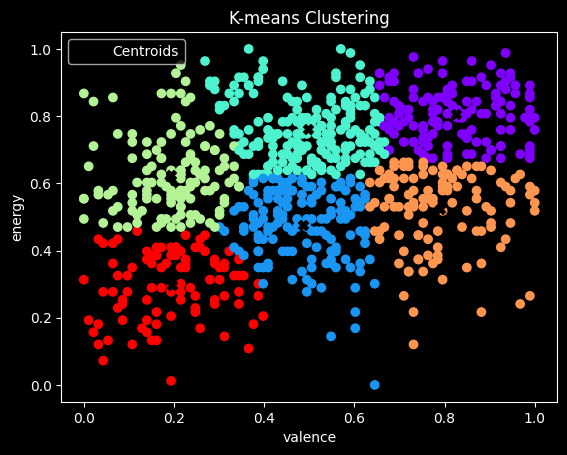

In [ ]:
data2 = df[["valence_%", "energy_%"]].to_numpy()
scaler2 = MinMaxScaler()
scaled_data2 = scaler.fit_transform(data2)
model2 = skcluster.KMeans(n_clusters=6, random_state=4, n_init = 10, max_iter = 1000)
model2.fit(scaled_data2)
cluster_assignments2 = model2.labels_
centroids2 = model2.cluster_centers_
plt.scatter(scaled_data2[:, 0], scaled_data2[:, 1], c=cluster_assignments2, cmap='rainbow')
plt.scatter(centroids2[:, 0], centroids2[:, 1], s=50, color='black', marker='X', label='Centroids')
plt.xlabel('valence')
plt.ylabel('energy')
plt.title('K-means Clustering')
plt.legend()
plt.show()

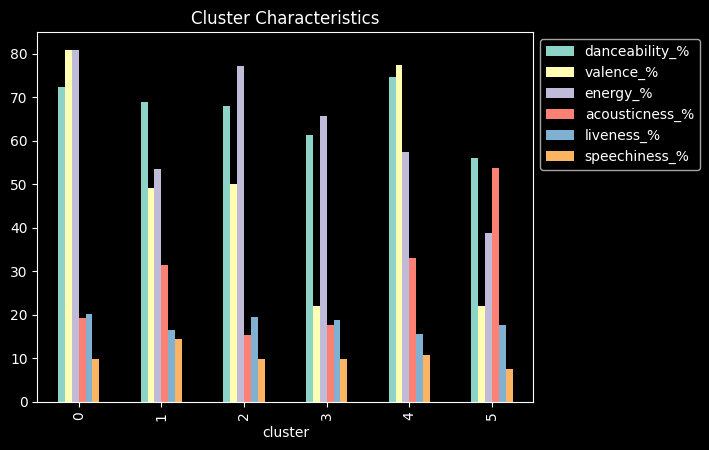

In [ ]:
clustered_df2 = df.copy()
cluster_labels2 = model2.labels_
clustered_df2['cluster'] = cluster_labels2
cluster_means2 = clustered_df2[["cluster", "danceability_%", "valence_%", "energy_%", "acousticness_%", "liveness_%", "speechiness_%"]].groupby('cluster').mean()
cluster_means2.plot(kind='bar')
plt.title('Cluster Characteristics')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

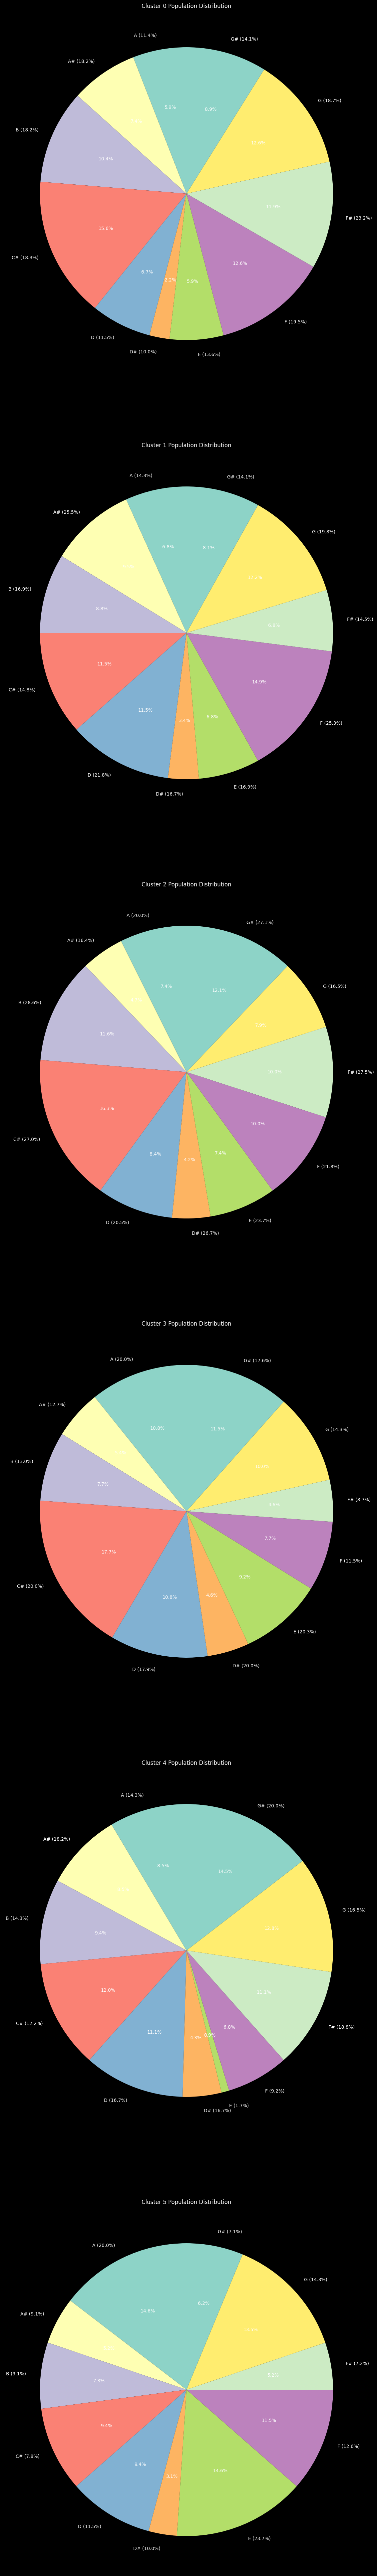

In [ ]:
cluster_key_dist2 = clustered_df2.groupby('cluster')["key"].value_counts()
cluster_key_pop2 = clustered_df2.groupby('cluster')["key"].value_counts().groupby("cluster").sum()
cluster_pop_distribution2 = pd.DataFrame({}, columns=["cluster", "key", "population"])
for index, value in cluster_key_dist2.items():
  cluster, key = index
  cluster_pop_distribution2.loc[len(cluster_pop_distribution2.index)] = [cluster, key, value]
grouped_cluster_pop_distribution2 = cluster_pop_distribution2.groupby("cluster")
key_pop = pd.DataFrame({})
key_pop['key'] = df['key'].unique()
key_pop['population'] = key_pop['key'].map(df['key'].value_counts())
key_pop = key_pop.sort_values(by=['key']).reset_index(drop=True)
fig, axs = plt.subplots(nrows=len(grouped_cluster_pop_distribution2.groups.keys()), figsize=(130, 100))
for index, name in enumerate(grouped_cluster_pop_distribution2.groups.keys()):
  new_clustered_df2 = grouped_cluster_pop_distribution2.get_group(name).sort_values(by="key")
  new_clustered_df2['population_percentage'] = new_clustered_df2['population'] / new_clustered_df2['key'].map(key_pop.set_index('key')['population']) * 100
  labels = [f'{key} ({pop:.1f}%)' for key, pop in zip(new_clustered_df2["key"], new_clustered_df2["population_percentage"])]
  axs[index].pie(new_clustered_df2["population"], labels=labels, autopct='%1.1f%%', startangle=90)
  axs[index].set_title(f'Cluster {name} Population Distribution')
plt.show()


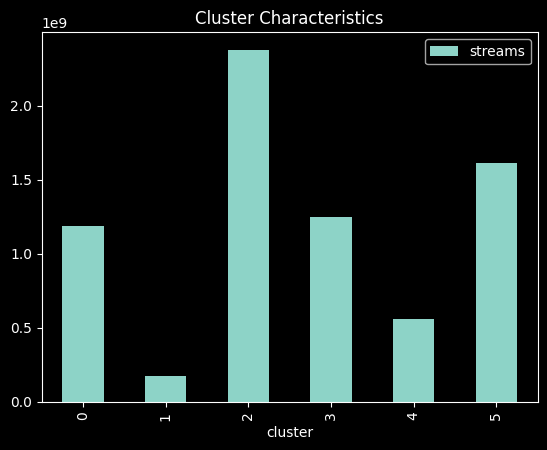

In [ ]:
cluster_means = clustered_df[["cluster", "streams"]].groupby('cluster').mean()
cluster_means.plot(kind='bar')
plt.title('Cluster Characteristics')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()